In [2]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import operator
import pandas as pd
import pickle
import random
import scipy
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors


import src.knntools as knntools
import src.postprocess as postprocess
import src.preprocess as preprocess
import src.tfidftools as tfidftools
import src.tools as tools
import src.recencytools as recency
import src.scoring as scoring

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
path_to_data = 'data/'

training = pd.read_csv(path_to_data + 'training_set.csv', sep=',', header=0)

training_info = pd.read_csv(
    path_to_data + 'training_info.csv', sep=',', parse_dates=True, header=0)

test = pd.read_csv(path_to_data + 'test_set.csv', sep=',', header=0)

test_info = pd.read_csv(path_to_data + 'test_info.csv',
                        sep=',', parse_dates=True, header=0)
path_to_results = 'results/'

In [4]:
train_info, train_email_ids_per_sender, val_info, val_email_ids_per_sender = scoring.get_train_val(training, training_info, train_frac=0.95)

Processing training !

Processing val !



In [5]:
token_dict = preprocess.body_dict_from_panda(train_info)

In [6]:
# Compute tfidf variables
tfidf_model, tfidf_matrix, tfidf_mids = tfidftools.get_tfidf(token_dict, 0.001, 0.10)

In [8]:
print(tfidf_matrix.shape)

(41432, 8240)


In [21]:
nb_neighbors_list = [45, 50, 55, 60]


In [22]:
nb_recipients = 10
scores = []

for nb_neighbors in nb_neighbors_list:
    mid_recipient_scores = knntools.compute_similarity_scores(tfidf_model, tfidf_matrix,
                                  tfidf_mids, train_info, val_info, nb_similars=nb_neighbors)
    knn_predictions = knntools.similar_dic_to_standard(mid_recipient_scores, nb_recipients)
    current_score = scoring.compute_prediction_mad(knn_predictions, val_info)
    path_to_ranks = 'ranks_val/knn-k-{nb_neighbors}-rec-{nb_recip}'.format(nb_neighbors=nb_neighbors,
                                                                     nb_recip=nb_recipients)
    with open(path_to_ranks, 'wb') as infile:
              pickle.dump(knn_predictions, infile)
    scores.append(current_score)
    print(scores)

[0.23253076759258393]
[0.23253076759258393, 0.23472187565739017]
[0.23253076759258393, 0.23472187565739017, 0.23271906882881532]
[0.23253076759258393, 0.23472187565739017, 0.23271906882881532, 0.23378861699722597]


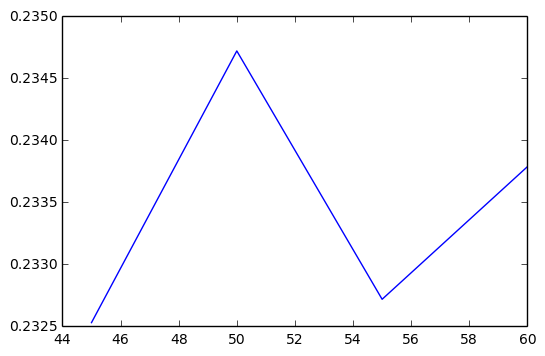

In [23]:
plt.plot(nb_neighbors_list, scores)

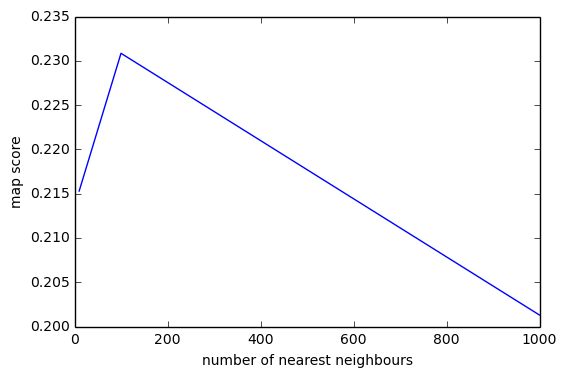

In [39]:
plt.plot(nb_neighbors_list, scores)
plt.xlabel('number of nearest neighbours')
plt.ylabel('map score')
plt.show()

In [48]:
best_neighbor_nb = 50
mid_recipient_scores = knntools.compute_similarity_scores(tfidf_model, tfidf_matrix,
                                  tfidf_mids, train_info, val_info, nb_similars=best_neighbor_nb)


In [49]:
knn_predictions = knntools.similar_dic_to_standard(mid_recipient_scores, keep_all=True)
best_score = scoring.compute_prediction_mad(knn_predictions, val_info)
print(best_score)

0.234852695217


In [47]:
path_to_ranks = 'ranks_val/knn-k-{nb_neighbors}-rec-all'.format(nb_neighbors=best_neighbor_nb)
with open(path_to_ranks, 'wb') as infile:
          pickle.dump(knn_predictions, infile)